In [ ]:
# Libraries set up
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import re

# Importsfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.utils.class_weight import compute_class_weight


In [16]:
# Load data
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
variables_df = pd.read_csv('VariableDefinitions.csv')
samplesub_df = pd.read_csv('SampleSubmission.csv')
extradata_df = pd.read_csv('extra_data.csv')

In [17]:
train_df.shape

(373, 12)

In [ ]:
# Clean labels and merge rare categories
def clean_and_merge_labels(df):
    # Fix specific inconsistencies
    df.loc[df['MERCHANT_NAME'].str.contains('NAIVAS|CARREFOUR|QUICKMART|TUSKYS', case=False, na=False), 'MERCHANT_CATEGORIZED_AS'] = 'Groceries'
    df.loc[df['MERCHANT_NAME'].str.contains('SAFARICOM.*TUNUKIWA|AIRTIME|BUNDLES', case=False, na=False), 'MERCHANT_CATEGORIZED_AS'] = 'Data & WiFi'
    df.loc[df['MERCHANT_NAME'].str.contains('KPLC|ZUKU|DSTV|NHIF', case=False, na=False), 'MERCHANT_CATEGORIZED_AS'] = 'Bills & Fees'
    df.loc[df['MERCHANT_NAME'].str.contains('JAVA|CAFE|GALITOS|RESTAURANT', case=False, na=False), 'MERCHANT_CATEGORIZED_AS'] = 'Going out'
    # P2P to Family & Friends
    def is_p2p(merchant_name):
        s = str(merchant_name).strip()
        business_indicators = [
            'supermarket', 'limited', 'ltd', 'plc', 'corporation', 'corp', 
            'company', 'co', 'inc', 'enterprises', 'services', 'industries',
            'hotel', 'restaurant', 'bank', 'insurance', 'airlines', 'school',
            'hospital', 'pharmacy', 'mall', 'store', 'shop', 'market'
        ]
        s_lower = s.lower()
        if any(indicator in s_lower for indicator in business_indicators):
            return 0
        if s.isupper():
            return 0
        if any(char.isdigit() for char in s):
            return 0
        if re.match(r'^[A-Z][a-z]+(\\s[A-Z][a-z]+){1,2}$', s):
            return 1
        return 0
    df.loc[df.apply(lambda row: is_p2p(row['MERCHANT_NAME']) == 1, axis=1), 'MERCHANT_CATEGORIZED_AS'] = 'Family & Friends'
    # Merge rare
    merge_map = {
        'Education': 'Bills & Fees',
        'Health': 'Bills & Fees',
        'Emergency fund': 'Miscellaneous',
        'Rent / Mortgage': 'Bills & Fees',
        'Loan Repayment': 'Bills & Fees'
    }
    df['MERCHANT_CATEGORIZED_AS'] = df['MERCHANT_CATEGORIZED_AS'].replace(merge_map)
    return df

train_df = clean_and_merge_labels(train_df)
print('Updated category counts:')
print(train_df['MERCHANT_CATEGORIZED_AS'].value_counts())

Updated category counts:
MERCHANT_CATEGORIZED_AS
Bills & Fees        87
Miscellaneous       60
Groceries           55
Data & WiFi         43
Going out           41
Family & Friends    40
Transport & Fuel    29
Shopping            18
Name: count, dtype: int64


In [19]:
train_df.head()

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
0,2022-05-04 10:25:50.588042+00,UONSDA CHURCH MOGERE MWAYO TITHE,Bills & Fees,1700,2022-05-04 13:56:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_04mk78fa
1,2021-10-25 16:18:38.586837+00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00,False,25.0,Female,4,90000,ID_U9WZMGJZ,ID_04xkfb07
2,2022-05-20 14:17:30.917297+00,SAFARICOM OFFERS TUNUKIWA,Data & WiFi,20,2022-05-27 12:46:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_051urwuw
3,2022-04-12 15:59:14.139347+00,ZILLIONS CREDIT LIMITED,Bills & Fees,3800,2022-02-07 12:16:00+00,False,NaN,Male,5,252000,ID_3JA0MAFB,ID_0e1om7rz
4,2022-05-04 10:24:26.709045+00,MICHAEL MUSEMBI,Bills & Fees,60,2022-05-04 15:28:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_0kfcoawb


In [20]:
# Define expanded keyword lists and functions
data_keywords = ['tunukiwa', 'offers', 'bundles', 'airtime', 'cyber', 'safaricom', 'airtel', 'telkom']
bill_keywords = ['kplc', 'prepaid', 'postpaid', 'zuku', 'nairobi water', 'nhif', 'dstv']
bank_keywords = ['bank', 'equity', 'kcb', 'ncba', 'm-shwari']
supermarket_keywords = ['carrefour', 'quickmart', 'naivas', 'supermarket', 'tuskys']
transport_keywords = ['uber', 'bolt', 'parking', 'go']
loan_keywords = ['loan', 'credit', 'mogo']
health_keywords = ['pharmacy', 'hospital', 'clinic']

# P2P detection (already in app, sync here)
def is_p2p(merchant_name):
    s = str(merchant_name).strip()
    business_indicators = [
        'supermarket', 'limited', 'ltd', 'plc', 'corporation', 'corp', 
        'company', 'co', 'inc', 'enterprises', 'services', 'industries',
        'hotel', 'restaurant', 'bank', 'insurance', 'airlines', 'school',
        'hospital', 'pharmacy', 'mall', 'store', 'shop', 'market'
    ]
    s_lower = s.lower()
    if any(indicator in s_lower for indicator in business_indicators):
        return 0
    if s.isupper():
        return 0
    if any(char.isdigit() for char in s):
        return 0
    if re.match(r'^[A-Z][a-z]+(\\s[A-Z][a-z]+){1,2}$', s):
        return 1
    return 0

# Time part function
def get_part_of_day(hour):
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'

# Improved feature engineering with overrides
def engineer_features(input_df, merchant_counts=None):
    df = input_df.copy()
    # Time features
    df['PURCHASED_AT'] = pd.to_datetime(df['PURCHASED_AT'], errors='coerce').fillna(pd.Timestamp("2024-01-01"))
    df['purchase_hour'] = df['PURCHASED_AT'].dt.hour
    df['purchase_day_of_week'] = df['PURCHASED_AT'].dt.dayofweek
    df['purchase_month'] = df['PURCHASED_AT'].dt.month
    df['is_weekend'] = (df['purchase_day_of_week'] >= 5).astype(int)
    df['part_of_day'] = df['purchase_hour'].apply(get_part_of_day)
    # P2P
    df['is_p2p_payment'] = df['MERCHANT_NAME'].apply(is_p2p)
    # Merchant cleaning
    df['merchant_name_clean'] = df['MERCHANT_NAME'].astype(str).str.lower().str.replace(r'[^a-z0-9\\s]', '', regex=True)
    df['merchant_norm'] = df['MERCHANT_NAME'].astype(str).str.upper().str.replace(r'[^A-Z0-9 ]', '', regex=True).str.strip()
    # Keyword flags
    df['is_data_purchase'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in data_keywords)).astype(int)
    df['is_bill_payment'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in bill_keywords)).astype(int)
    df['is_bank'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in bank_keywords)).astype(int)
    df['is_supermarket'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in supermarket_keywords)).astype(int)
    df['is_transport'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in transport_keywords)).astype(int)
    df['is_loan'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in loan_keywords)).astype(int)
    df['is_health'] = df['merchant_name_clean'].apply(lambda x: any(k in x for k in health_keywords)).astype(int)
    # Stronger overrides for common confusions
    for idx, row in df.iterrows():
        name = row['merchant_name_clean']
        if 'tunukiwa' in name or 'bundles' in name or 'airtime' in name:
            df.at[idx, 'is_data_purchase'] = 1
            df.at[idx, 'is_bill_payment'] = 0  # Override
        if 'naivas' in name or 'carrefour' in name:
            df.at[idx, 'is_supermarket'] = 1
    # Frequency
    if merchant_counts is not None:
        df['merchant_frequency'] = df['merchant_norm'].map(merchant_counts).fillna(0)
    else:
        df['merchant_frequency'] = 0
    # Logs
    df['PURCHASE_VALUE'] = pd.to_numeric(df['PURCHASE_VALUE'], errors='coerce').fillna(0)
    df['USER_INCOME'] = pd.to_numeric(df['USER_INCOME'], errors='coerce').fillna(0)
    df['purchase_value_log'] = np.log1p(df['PURCHASE_VALUE'])
    df['user_income_log'] = np.log1p(df['USER_INCOME'])
    # Categories
    pod_categories = ['morning', 'afternoon', 'evening', 'night']
    gender_categories = ['Male', 'Female']
    df['part_of_day'] = pd.Categorical(df['part_of_day'], categories=pod_categories)
    df['USER_GENDER'] = pd.Categorical(df['USER_GENDER'], categories=gender_categories)
    # One-hot (drop_first=False to match app)
    df = pd.get_dummies(df, columns=['USER_GENDER', 'part_of_day'], drop_first=False)
    # Drop extras
    drop_cols = ['MERCHANT_NAME', 'PURCHASED_AT', 'MERCHANT_CATEGORIZED_AT', 'IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'USER_ID', 'Transaction_ID', 'merchant_name_clean', 'merchant_norm']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
    # Handle missing dummies
    return df

In [21]:
# Prepare data
X = train_df.drop('MERCHANT_CATEGORIZED_AS', axis=1)
y = train_df['MERCHANT_CATEGORIZED_AS']

# Merchant counts for frequency
merchant_counts = train_df['MERCHANT_NAME'].value_counts().to_dict()
joblib.dump(merchant_counts, 'merchant_counts.joblib')

# Engineer features
X_eng = engineer_features(X, merchant_counts)

# Impute missing values (median for numerics)
imputer = SimpleImputer(strategy='median')
X_eng = pd.DataFrame(imputer.fit_transform(X_eng), columns=X_eng.columns, index=X_eng.index)
imputation_values = dict(zip(X_eng.columns, imputer.statistics_))
joblib.dump(imputation_values, 'imputation_values.joblib')

# Scale specific columns
cols_to_scale = ['USER_AGE', 'USER_HOUSEHOLD', 'purchase_hour', 'purchase_day_of_week', 'purchase_month', 'merchant_frequency', 'purchase_value_log', 'user_income_log']
scaler = StandardScaler()
X_eng[cols_to_scale] = scaler.fit_transform(X_eng[cols_to_scale])
joblib.dump(scaler, 'scaler.joblib')

# Label encode y
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, 'label_encoder.joblib')

# Save expected columns
expected_columns = X_eng.columns.tolist()
joblib.dump(expected_columns, 'final_model_columns.joblib')

# Split (no SMOTE)
X_train, X_val, y_train, y_val = train_test_split(X_eng, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


Logistic Regression
                  precision    recall  f1-score   support

    Bills & Fees       0.33      0.18      0.23        17
     Data & WiFi       0.33      0.78      0.47         9
Family & Friends       0.25      0.25      0.25         8
       Going out       0.30      0.38      0.33         8
       Groceries       0.40      0.36      0.38        11
   Miscellaneous       0.20      0.08      0.12        12
        Shopping       0.00      0.00      0.00         4
Transport & Fuel       0.12      0.17      0.14         6

        accuracy                           0.28        75
       macro avg       0.24      0.27      0.24        75
    weighted avg       0.27      0.28      0.26        75



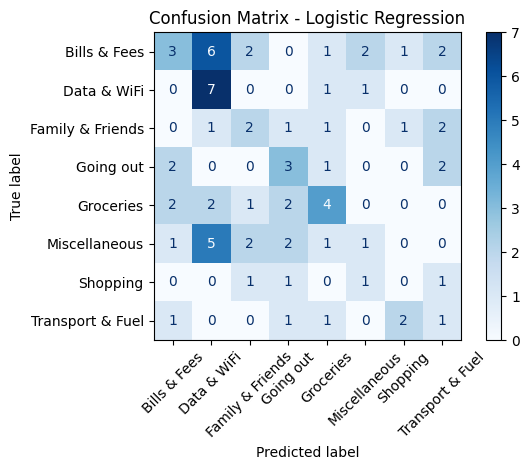

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best RF params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}

Random Forest (Regularized)
                  precision    recall  f1-score   support

    Bills & Fees       0.67      0.59      0.62        17
     Data & WiFi       0.75      1.00      0.86         9
Family & Friends       0.57      0.50      0.53         8
       Going out       0.31      0.50      0.38         8
       Groceries       0.77      0.91      0.83        11
   Miscellaneous       1.00      0.42      0.59        12
        Shopping       0.20      0.25      0.22         4
Transport & Fuel       0.00      0.00      0.00         6

        accuracy                           0.57        75
       macro avg       0.53      0.52      0.51        75
    weighted avg       0.62      0.57      0.57        75



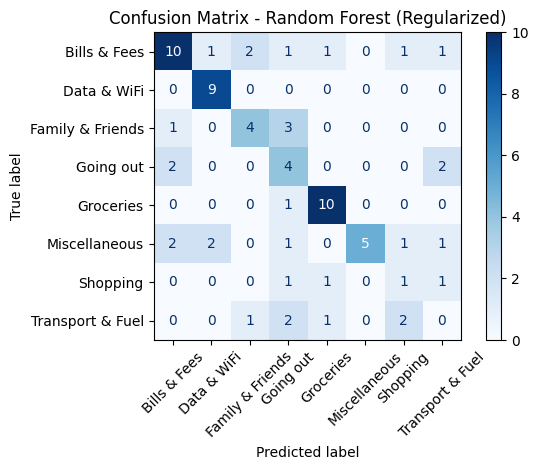

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits

Best XGBoost params (anti-overfit): {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.7}

XGBoost (Regularized)
                  precision    recall  f1-score   support

    Bills & Fees       0.58      0.65      0.61        17
     Data & WiFi       0.75      1.00      0.86         9
Family & Friends       0.50      0.50      0.50         8
       Going out       0.50      0.62      0.56         8
       Groceries       0.83      0.91      0.87        11
   Miscellaneous       0.71      0.42      0.53        12
        Shopping       0.25      0.25      0.25         4
Transport & Fuel       0.00      0.00      0.00         6

        accuracy                           0.60        75
       macro avg       0.52      0.54      0.52        75
    weighted avg       0.58      0.60      0.58        75

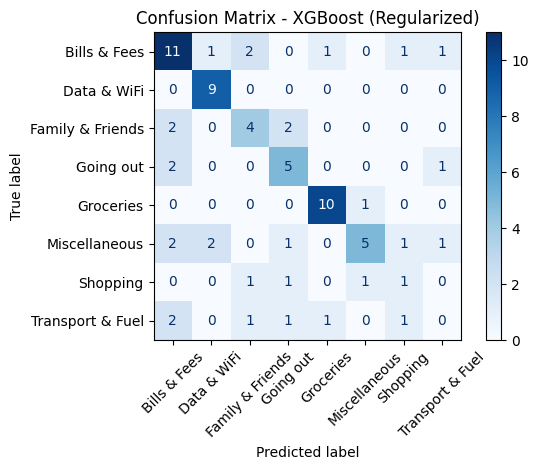


CatBoost
                  precision    recall  f1-score   support

    Bills & Fees       0.55      0.71      0.62        17
     Data & WiFi       0.67      0.67      0.67         9
Family & Friends       0.43      0.38      0.40         8
       Going out       0.45      0.62      0.53         8
       Groceries       0.90      0.82      0.86        11
   Miscellaneous       0.71      0.42      0.53        12
        Shopping       0.17      0.25      0.20         4
Transport & Fuel       0.00      0.00      0.00         6

        accuracy                           0.55        75
       macro avg       0.48      0.48      0.47        75
    weighted avg       0.55      0.55      0.54        75



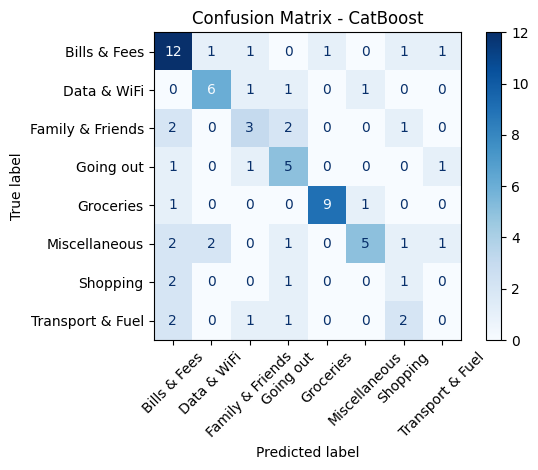

FINAL MODEL COMPARISON


,Model,Train Accuracy,Train F1,Train Precision,Train Recall,Val Accuracy,Val F1,Val Precision,Val Recall
0,XGBoost (Regularized),0.7852,0.7825,0.7658,0.8225,0.6000,0.5212,0.5158,0.5435
1,Random Forest (Regularized),0.8154,0.8034,0.7938,0.8381,0.5733,0.5050,0.5331,0.5205
2,CatBoost,0.9933,0.9931,0.9910,0.9954,0.5467,0.4740,0.4845,0.4822
3,Logistic Regression,0.3691,0.3416,0.3498,0.3778,0.2800,0.2403,0.2427,0.2741



Saved BEST model: **XGBoost (Regularized)** → 'best_model_classifier'


In [ ]:


# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))
sample_weights = [weight_dict[label] for label in y_train]

#  Results storage
results = []

#  Evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    results.append({
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, train_preds),
        'Train F1': f1_score(y_train, train_preds, average='macro'),
        'Train Precision': precision_score(y_train, train_preds, average='macro'),
        'Train Recall': recall_score(y_train, train_preds, average='macro'),
        'Val Accuracy': accuracy_score(y_val, val_preds),
        'Val F1': f1_score(y_val, val_preds, average='macro'),
        'Val Precision': precision_score(y_val, val_preds, average='macro'),
        'Val Recall': recall_score(y_val, val_preds, average='macro')
    })

    print(f"\n{model_name}")
    print(classification_report(y_val, val_preds, target_names=le.classes_))
    cm = confusion_matrix(y_val, val_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

    return val_preds

# Logistic Regression (baseline)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_val_preds = evaluate_model(lr_model, X_train, y_train, X_val, y_val, "Logistic Regression")

#  TUNED RANDOM FOREST 
rf_param_dist = {
    'n_estimators'      : [200, 300, 400],
    'max_depth'         : [8, 10, 12, 15],           # ← Lower depth
    'min_samples_split' : [10, 15, 20],             # ← Prevent tiny splits
    'min_samples_leaf'  : [5, 10, 15],              # ← Prevent tiny leaves
    'max_features'      : [0.5, 0.6, 0.7],          # ← Use ~50-70% of features
    'bootstrap'         : [True],
    'class_weight'      : ['balanced']
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        oob_score=True,
        warm_start=False
    ),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
print("\nBest RF params:", rf_search.best_params_)

rf_val_preds = evaluate_model(rf_best, X_train, y_train, X_val, y_val, "Random Forest (Regularized)")

# TUNED XGBOOST (SIMPLE + REGULARIZED)
xgb_param_grid = {
    'max_depth'        : [3, 4, 5],                 # ← Shallow trees
    'n_estimators'     : [100, 150, 200],
    'learning_rate'    : [0.05, 0.1],
    'subsample'        : [0.7, 0.8],
    'colsample_bytree' : [0.7, 0.8],
    'gamma'            : [0.1, 0.3],
    'min_child_weight' : [3, 5, 7],
    'reg_alpha'        : [0.1, 0.5, 1.0],           # ← L1
    'reg_lambda'       : [1.0, 1.5, 2.0]            # ← L2
}

xgb_search = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss',
        early_stopping_rounds=50,   # ← Stop early
        verbosity=0
    ),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_best = xgb_search.best_estimator_
print("\nBest XGBoost params (anti-overfit):", xgb_search.best_params_)

xgb_val_preds = evaluate_model(xgb_best, X_train, y_train, X_val, y_val, "XGBoost (Regularized)")

#  CatBoost (baseline)
cb_model = CatBoostClassifier(class_weights=class_weights, random_state=42, verbose=0)
cb_model.fit(X_train, y_train)
cb_val_preds = evaluate_model(cb_model, X_train, y_train, X_val, y_val, "CatBoost")

#  FINAL TABLE: Best model first
df_results = pd.DataFrame(results).round(4)
df_results = df_results.sort_values(by='Val F1', ascending=False).reset_index(drop=True)

styled = df_results.style \
    .highlight_max(subset=['Val F1'], color='lightgreen') \
    .format("{:.4f}", subset=[c for c in df_results.columns if c != 'Model'])

print("FINAL MODEL COMPARISON")
display(styled)

# SAVE THE BEST MODEL
best_model_name = df_results.iloc[0]['Model']
best_model_map = {
    "Logistic Regression": lr_model,
    "Random Forest (Regularized)": rf_best,
    "XGBoost (Regularized)": xgb_best,
    "CatBoost": cb_model
}
best_model = best_model_map[best_model_name]

joblib.dump(best_model, 'best_model_classifier')
print(f"\nSaved BEST model: **{best_model_name}** → 'best_model_classifier'")

In [ ]:
#  SAVE THE BEST MODEL
best_model_name = df_results.iloc[0]['Model']
best_model_map = {
    "Logistic Regression": lr_model,
    "Random Forest (Regularized)": rf_best,
    "XGBoost (Regularized)": xgb_best,
    "CatBoost": cb_model
}
best_model = best_model_map[best_model_name]

joblib.dump(best_model, 'best_model_classifier')
print(f"\nSaved BEST model: **{best_model_name}** → 'best_model_classifier1'")


Saved BEST model: **XGBoost (Regularized)** → 'best_model_classifier1'


In [ ]:
# Mistakes report 
labels_df = pd.DataFrame({
    'True_Label': le.inverse_transform(y_val),
    'Predicted_Label': le.inverse_transform(xgb_val_preds)
}, index=X_val.index)  # Use the index from X_val

misclassified_labels_df = labels_df[labels_df['True_Label'] != labels_df['Predicted_Label']]
misclassified_indices = misclassified_labels_df.index

# Pull from original X 
original_data_df = X.loc[misclassified_indices]

final_report = pd.concat([original_data_df[['MERCHANT_NAME', 'PURCHASE_VALUE']], misclassified_labels_df], axis=1)

print("The model's mistakes:")
print(final_report.to_markdown(index=False))

The model's mistakes:
| MERCHANT_NAME                   |   PURCHASE_VALUE | True_Label       | Predicted_Label   |
|:--------------------------------|-----------------:|:-----------------|:------------------|
| GLADWELL MBURU                  |              200 | Miscellaneous    | Transport & Fuel  |
| HARRISON JUMA AYUAK             |               60 | Going out        | Miscellaneous     |
| RUBIS ENJOY UN AVENUE           |               60 | Going out        | Bills & Fees      |
| BRIOCHE RUBIS LANGATA           |              500 | Going out        | Transport & Fuel  |
| APS ABC PARKING                 |               50 | Transport & Fuel | Bills & Fees      |
| CAPTON ENTERPRISES NRBI WEST    |             1100 | Transport & Fuel | Groceries         |
| ROBERT KARIUKI                  |              280 | Bills & Fees     | Transport & Fuel  |
| CHRISTINE OOKO                  |             1000 | Miscellaneous    | Bills & Fees      |
| NAIROBI JAVA HOUSE SARIT CENTRE |   